# Prediction of Active Enhancers with FFNN

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from typing import List
from tqdm.auto import tqdm
from keras_tqdm import TQDMNotebookCallback as ktqdm
from multiprocessing import cpu_count
import compress_json
import os
from barplots import barplots

## Models

In [22]:
models = []
kwargs = []

### Decision Trees

In [23]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=50,
    random_state=42,
    class_weight="balanced"
)

models.append(decision_tree)
kwargs.append({})

### Random forests

In [25]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(
    n_estimators=500,
    criterion="gini",
    max_depth=30,
    random_state=42,
    class_weight="balanced",
    n_jobs=cpu_count()
)

models.append(random_forest)
kwargs.append({})

### Perceptron

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping


perceptron = Sequential([
    Input(shape=(104, )),
    Dense(1, activation="sigmoid")
], "Perceptron")

perceptron.compile(
    optimizer="nadam",
    loss="binary_crossentropy"
)

models.append(perceptron)
kwargs.append(dict(
    epochs=1000,
    batch_size=1024,
    validation_split=0.1,
    shuffle=True,
    verbose=False,
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min", patience=50),
        ktqdm(leave_outer=False)
    ]
))

### Multi-Layer Perceptron (MLP)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

mlp = Sequential([
    Input(shape=(104, )),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
], "MLP")

mlp.compile(
    optimizer="nadam",
    loss="binary_crossentropy"
)

models.append(mlp)
kwargs.append(dict(
    epochs=1000,
    batch_size=1024,
    validation_split=0.1,
    shuffle=True,
    verbose=False,
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min", patience=50),
        ktqdm(leave_outer=False)
    ]
))

### Feed-Forward Neural Network (FFNN)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout


ffnn = Sequential([
    Input(shape=(104, )),
    Dense(256, activation="relu"),
    Dense(128),
    BatchNormalization(),
    Activation("relu"),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
], "FFNN")

ffnn.compile(
    optimizer="nadam",
    loss="binary_crossentropy"
)

models.append(ffnn)
kwargs.append(dict(
    epochs=1000,
    batch_size=1024,
    validation_split=0.1,
    shuffle=True,
    verbose=False,
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min", patience=50),
        ktqdm(leave_outer=False)
    ]
))

ffnn.summary()

Model: "FFNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               26880     
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 32)                2080   

## FFNN2

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout


ffnn2 = Sequential([
    Input(shape=(104, )),
    Dense(256, activation="relu"),
    Dense(128),
    BatchNormalization(),
    Activation("relu"),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dropout(0.5),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
], "FFNN2")

ffnn2.compile(
    optimizer="nadam",
    loss="binary_crossentropy"
)

models.append(ffnn2)
kwargs.append(dict(
    epochs=1000,
    batch_size=1024,
    validation_split=0.1,
    shuffle=True,
    verbose=False,
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min", patience=10, restore_best_weights=True),
        ktqdm(leave_outer=False)
    ]
))

ffnn2.summary()

Model: "FFNN2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 256)               26880     
_________________________________________________________________
dense_32 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_34 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0     

## Meta-models
Meta-models are models that generate models: this means that, usually, they define hyper-parameters space that are then explored through some (tipically iterative) procedure using some defined score to optimize for choosing the best possible model. Depending on the kind of hyper-parameters exploration to intend to do, you might choose a different method.

Often this kind of optimization are executed on clusters, expecially when tackling the space of structures of neural networks, so for now I will limit to show some of the alternatives without actually running the optimization.

Other important and useful methods are the [Tree of Parzen](https://github.com/hyperopt/hyperopt) and [Bayesian Optimization](https://github.com/fmfn/BayesianOptimization), but I could not manage to fit them within this lesson.

### Grid search
A grid search is just that: you define a grid of hyper-parameters to explore (for instance for two hyper-parameters with 8 available options you get a chess-board of possible combinations) and iteratively you start, one by one (or in parallel) to explore each possible combination.

When the time required by the fit of the model is not a lot and the combination of possible parameters are not that many, one can thing about doing am exhaustive Grid Search.

Tipically, in a cluster scenario, you would run a combination on each available cluster node in parallel.

#### Grid search with Sklearn
Our loyal friend Sklearn, as many other times, has us covered also for a [simple implementation of a Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) (that can also be simply implemented by a product of the hyper-parameters space and a for loop). You can use their implementation as follows:

In [30]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

iris = datasets.load_iris()
parameters = dict(
    max_depth=[2, 10, 20, 50, None],
    class_weight=[None, "balanced"]
)
grid = GridSearchCV(DecisionTreeClassifier(), parameters, scoring="balanced_accuracy")
grid.fit(iris.data, iris.target)

print(grid.best_params_, grid.best_score_)

{'class_weight': None, 'max_depth': 20} 0.9666666666666668


#### Distributed grid search with Ray
[Ray](https://github.com/ray-project/ray) is a library for, among other things, running distributed hyper-parameters search. It supports all the methods presented in this lesson, and can be used in multiple settings, from on your own computer for a parallel search up to computation clusters.

Here the version proposed is equivalent to the one used in Sklearn, but can be scaled. You can reasonably think to setup a Ray cluster on your machines if they are comparable in hardware terms for running part of your project if you consider using this hyper-parameters search solution.

In [31]:
from ray import tune
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

def train(config):
    X, y = datasets.load_iris(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    tree = DecisionTreeClassifier(**config)
    tree.fit(X_train, y_train)
    tune.track.log(balanced_accuracy_score=balanced_accuracy_score(y_test, tree.predict(X_test)))


analysis = tune.run(
    train, config = dict(
        max_depth=tune.grid_search([2, 10, 20, 50, None]),
        class_weight=tune.grid_search([None, "balanced"])
    )
)

print("Best config: ", analysis.get_best_config(metric="balanced_accuracy_score"))

# Get a dataframe for analyzing trial results.
df = analysis.dataframe()

2020-04-18 08:09:00,466	WARNING tune.py:312 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.
2020-04-18 08:09:00,485	ERROR logger.py:193 -- pip install 'ray[tune]' to see TensorBoard files.
2020-04-18 08:09:00,486	WARNING logger.py:308 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.


Trial name,status,loc,class_weight,max_depth
train_00000,RUNNING,,,2
train_00001,PENDING,,balanced,2
train_00002,PENDING,,,10
train_00003,PENDING,,balanced,10
train_00004,PENDING,,,20
train_00005,PENDING,,balanced,20
train_00006,PENDING,,,50
train_00007,PENDING,,balanced,50
train_00008,PENDING,,,
train_00009,PENDING,,balanced,


2020-04-18 08:09:00,517	ERROR logger.py:193 -- pip install 'ray[tune]' to see TensorBoard files.
2020-04-18 08:09:00,517	WARNING logger.py:308 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.
2020-04-18 08:09:00,535	ERROR logger.py:193 -- pip install 'ray[tune]' to see TensorBoard files.
2020-04-18 08:09:00,535	WARNING logger.py:308 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.
2020-04-18 08:09:00,554	ERROR logger.py:193 -- pip install 'ray[tune]' to see TensorBoard files.
2020-04-18 08:09:00,555	WARNING logger.py:308 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.
2020-04-18 08:09:00,572	ERROR logger.py:193 -- pip install 'ray[tune]' to see TensorBoard files.
2020-04-18 08:09:00,572	WARNING logger.py:308 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.
2020-04-18 08:09:00,590	ERROR logger.py:193 -- pip install 'ray[tune]' to see TensorBoard files.
2020-04-18 08:09:00,591	WARNING logger.py:308 -- Could not 

Result for train_00000:
  balanced_accuracy_score: 0.9791666666666666
  date: 2020-04-18_08-09-01
  done: false
  experiment_id: 661a85c050d249258d976f15205c4435
  experiment_tag: 0_class_weight=None,max_depth=2
  hostname: cdce28121c93
  iterations_since_restore: 1
  node_ip: 192.168.127.128
  pid: 32403
  time_since_restore: 0.00587773323059082
  time_this_iter_s: 0.00587773323059082
  time_total_s: 0.00587773323059082
  timestamp: 1587197341
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00000'
  
(pid=32403) 2020-04-18 08:09:01,263	INFO trainable.py:217 -- Getting current IP.
Result for train_00002:
  balanced_accuracy_score: 1.0
  date: 2020-04-18_08-09-01
  done: false
  experiment_id: 74198b1578414930a61b654690106b6d
  experiment_tag: 2_class_weight=None,max_depth=10
  hostname: cdce28121c93
  iterations_since_restore: 1
  node_ip: 192.168.127.128
  pid: 32438
  time_since_restore: 0.009016752243041992
  time_this_iter_s: 0.009016752243041992
  time_total_s: 0

Trial name,status,loc,class_weight,max_depth,iter,total time (s)
train_00000,TERMINATED,,,2,0,0.00587773
train_00001,TERMINATED,,balanced,2,0,0.0117972
train_00002,TERMINATED,,,10,0,0.00901675
train_00003,TERMINATED,,balanced,10,0,0.0353198
train_00004,TERMINATED,,,20,0,0.00569916
train_00005,TERMINATED,,balanced,20,0,0.01125
train_00006,TERMINATED,,,50,0,0.00822997
train_00007,TERMINATED,,balanced,50,0,0.00961804
train_00008,TERMINATED,,,,0,0.0101931
train_00009,TERMINATED,,balanced,,0,0.0118172



Best config:  {'max_depth': 10, 'class_weight': None}


### Random search
A random search is another approach for identifying an optimal set of hyper-parameters. It is a good alternative to grid search when either the time required to fit a model is really high or the hyper-parameters space is very huge.

[Grid search can be outperformed by random search in these settings](http://www.jmlr.org/papers/v13/bergstra12a.html).

As for grid search, also random search is vastly parallelizable and can be run in clusters.

A significant difference between grid search and random search, is that random search can also sample random points from a continuos distribution, whereas grid search will turn the continuos distribution into a discrete one by sampling it uniformely.

#### Random search with Sklearn
As before, [we can use the implementation from Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

In [32]:
from sklearn import svm, datasets
from sklearn.model_selection import RandomizedSearchCV

iris = datasets.load_iris()
parameters = dict(
    max_depth=[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, None],
    class_weight=[None, "balanced"]
)
random_search = RandomizedSearchCV(DecisionTreeClassifier(), parameters, scoring="balanced_accuracy", n_iter=10)
random_search.fit(iris.data, iris.target)

print(random_search.best_params_, random_search.best_score_)

{'max_depth': 70, 'class_weight': 'balanced'} 0.9666666666666668


## The experimental setup
After having **well defined** the models we intend to explore, we have to define how we intend to evaluate them, the data used and basically **ALL** the tiny seeming uninportant aspects that we will keep in consideration.

This part is **VERY** important and will help you avoid loosing a lot of time caused by reinveinting the wheel or making beginners' mistakes. 

If it is not already clear, **BEFORE WRITING A SINGLE LINE OF CODE WRITE YOUR EXPERIMENTAL SETUP IN YOUR PROJECT**. Here I showed you the models in code to help you understand them, but in a paper or in the project you should descrive the models you intend to explore in writing.

That said, let's begin: we will evaluate the models we have defined on the enhancers epigenomic dataset, using a 50-fold cross validation. 

## Retrieving the data

In [33]:
from epigenomic_dataset import load_epigenomes
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

# The considered window size
window_size = 200

# Retrieving the input data
X, y = load_epigenomes(
    cell_line = "GM12878",
    dataset = "fantom",
    regions = "enhancers",
    window_size = window_size
)
X = X.droplevel(1, axis=1)
y = y.values.ravel()

# Imputation of NaN Values
X[X.columns] = KNNImputer(n_neighbors=X.shape[0]//10).fit_transform(X)

# Robust normalization of the values
X[X.columns] = RobustScaler().fit_transform(X)

X = X.values

# Here one should feature selection. How can we do this?

In [34]:
from epigenomic_dataset import load_epigenomes
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

# The considered window size
window_size = 200

# Retrieving the input data
X, y = load_epigenomes(
    cell_line = "GM12878",
    dataset = "fantom",
    regions = "enhancers",
    window_size = window_size
)
X = X.droplevel(1, axis=1)

In [40]:
proteins = X[["USF2", "E2F4", "ETV6", "WRNIP1"]]

proteins[(proteins==0).any(axis=1)]

chrom                             USF2  E2F4  ETV6  WRNIP1
chrom chromStart chromEnd strand                          
chr1  839687     839887   .       1.38  1.15  0.62    0.00
      945789     945989   .       1.48  1.09  1.08    0.00
      1063878    1064078  .       2.26  1.73  0.84    0.00
      1070843    1071043  .       0.75  0.00  1.08    2.04
      1348590    1348790  .       0.00  0.58  1.26    1.36
...                                ...   ...   ...     ...
chrY  23402241   23402441 .       0.00  0.00  0.00    0.00
      23410476   23410676 .       0.00  0.00  0.26    0.00
      23412678   23412878 .       0.00  0.00  0.00    0.00
      28555197   28555397 .       0.00  0.00  0.00    0.00
      28555642   28555842 .       0.00  0.00  0.00    0.00

[5300 rows x 4 columns]

## Preparing the holdouts

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

splits = 51
holdouts = StratifiedShuffleSplit(n_splits=splits, test_size=0.2, random_state=42)

## Training the models

In [15]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, average_precision_score
from sanitize_ml_labels import sanitize_ml_labels

def report(y_true:np.ndarray, y_pred:np.ndarray)->np.ndarray:
    integer_metrics = accuracy_score, balanced_accuracy_score
    float_metrics = roc_auc_score, average_precision_score
    results1 = {
        sanitize_ml_labels(metric.__name__): metric(y_true, np.round(y_pred))
        for metric in integer_metrics
    }
    results2 = {
        sanitize_ml_labels(metric.__name__): metric(y_true, y_pred)
        for metric in float_metrics
    }
    return {
        **results1,
        **results2
    }

In [16]:
def precomputed(results, model:str, holdout:int)->bool:
    df = pd.DataFrame(results)
    if df.empty:
        return False
    return (
        (df.model == model) &
        (df.holdout == holdout)
    ).any()

In [17]:
if os.path.exists("results.json"):
    results = compress_json.local_load("results.json")
else:
    results = []
    
for i, (train, test) in tqdm(enumerate(holdouts.split(X, y)), total=splits, desc="Computing holdouts", dynamic_ncols=True):
    for model, params in tqdm(zip(models, kwargs), total=len(models), desc="Training models", leave=False, dynamic_ncols=True):
        model_name = (
            model.__class__.__name__
            if model.__class__.__name__ != "Sequential"
            else model.name
        )
        if precomputed(results, model_name, i):
            continue
        model.fit(X[train], y[train], **params)
        results.append({
            "model":model_name,
            "run_type":"train",
            "holdout":i,
            **report(y[train], model.predict(X[train]))
        })
        results.append({
            "model":model_name,
            "run_type":"test",
            "holdout":i,
            **report(y[test], model.predict(X[test]))
        })
        compress_json.local_dump(results, "results.json")

## Collecting the results

In [18]:
df = pd.DataFrame(results)
df = df.drop(columns=["holdout"])

df[:5]

,model,run_type,Accuracy,Balanced Accuracy,AUROC,AUPRC
0,DecisionTreeClassifier,train,0.999943,0.999960,0.999960,0.999795
1,DecisionTreeClassifier,test,0.749943,0.689828,0.689828,0.430826
2,RandomForestClassifier,train,1.000000,1.000000,1.000000,1.000000
3,RandomForestClassifier,test,0.826137,0.729755,0.729755,0.542366
4,Perceptron,train,0.829569,0.735908,0.850767,0.755522


In [19]:
barplots(
    df,
    groupby=["model", "run_type"],
    show_legend=False,
    height=5,
    orientation="horizontal"
)

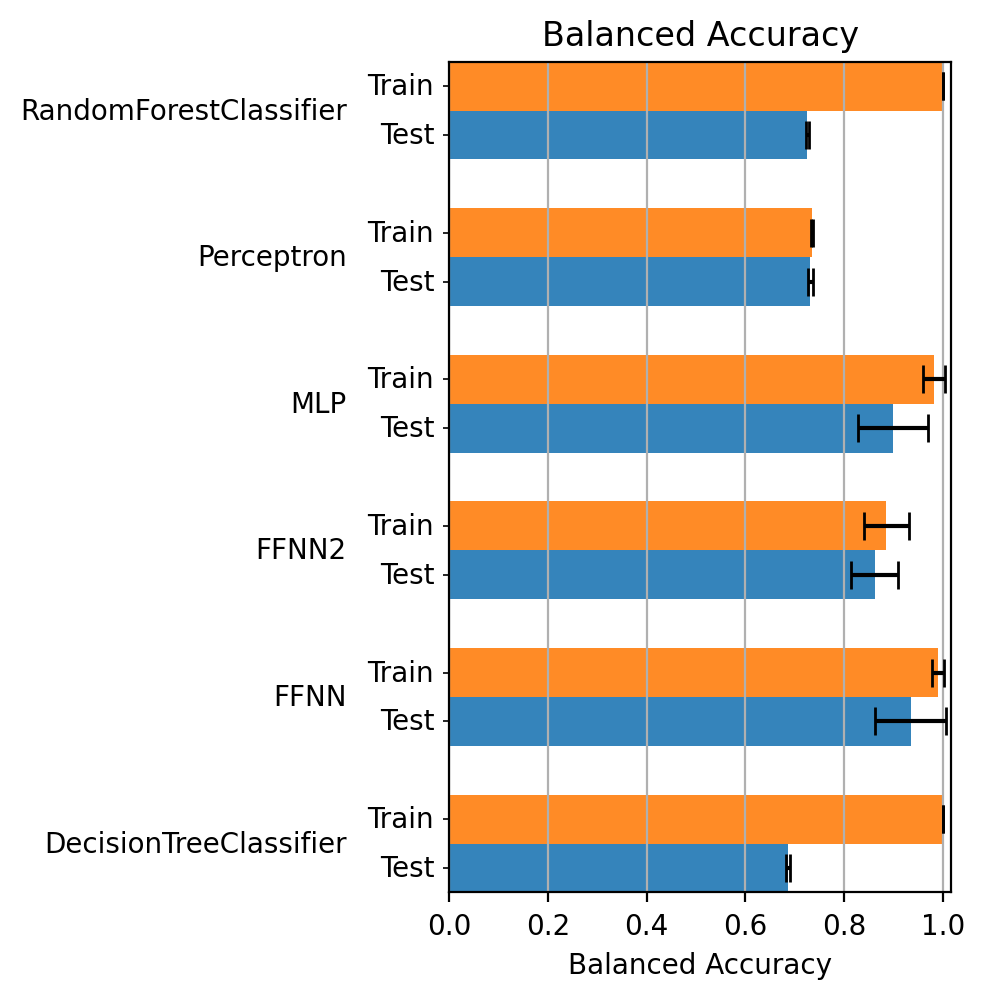

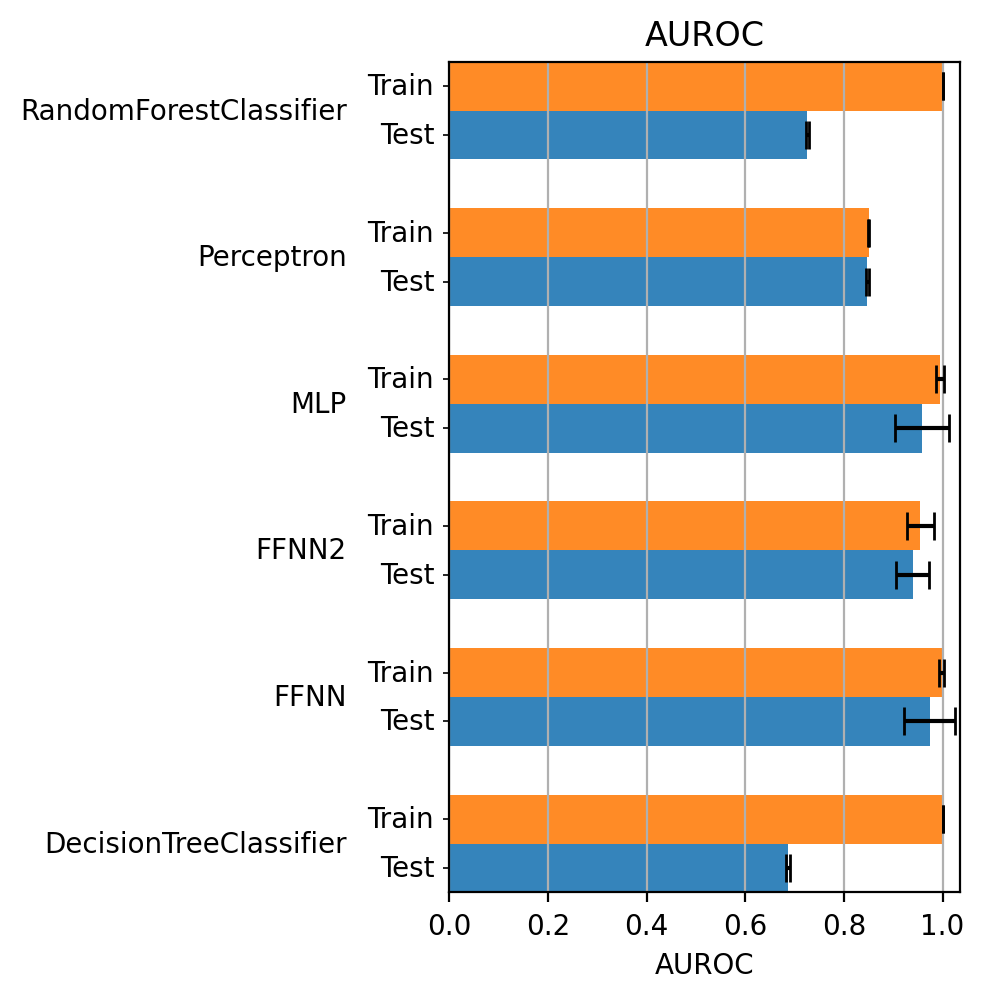

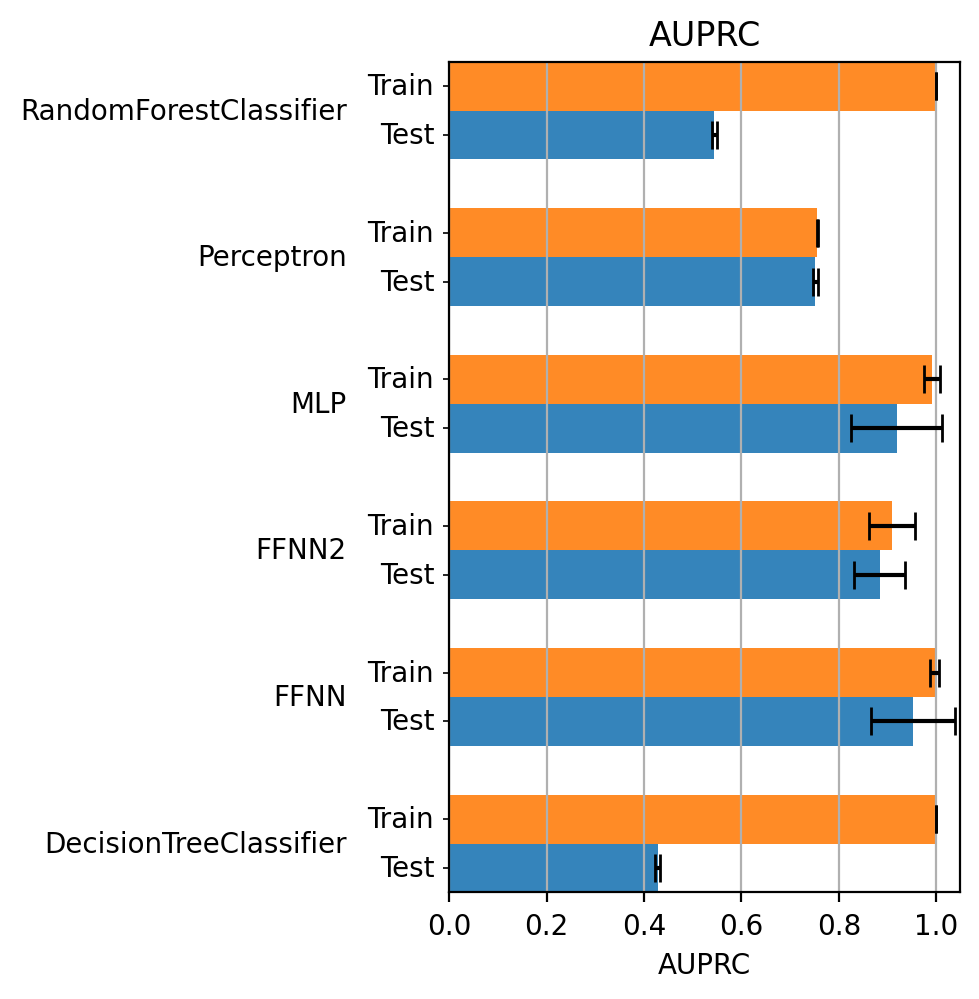

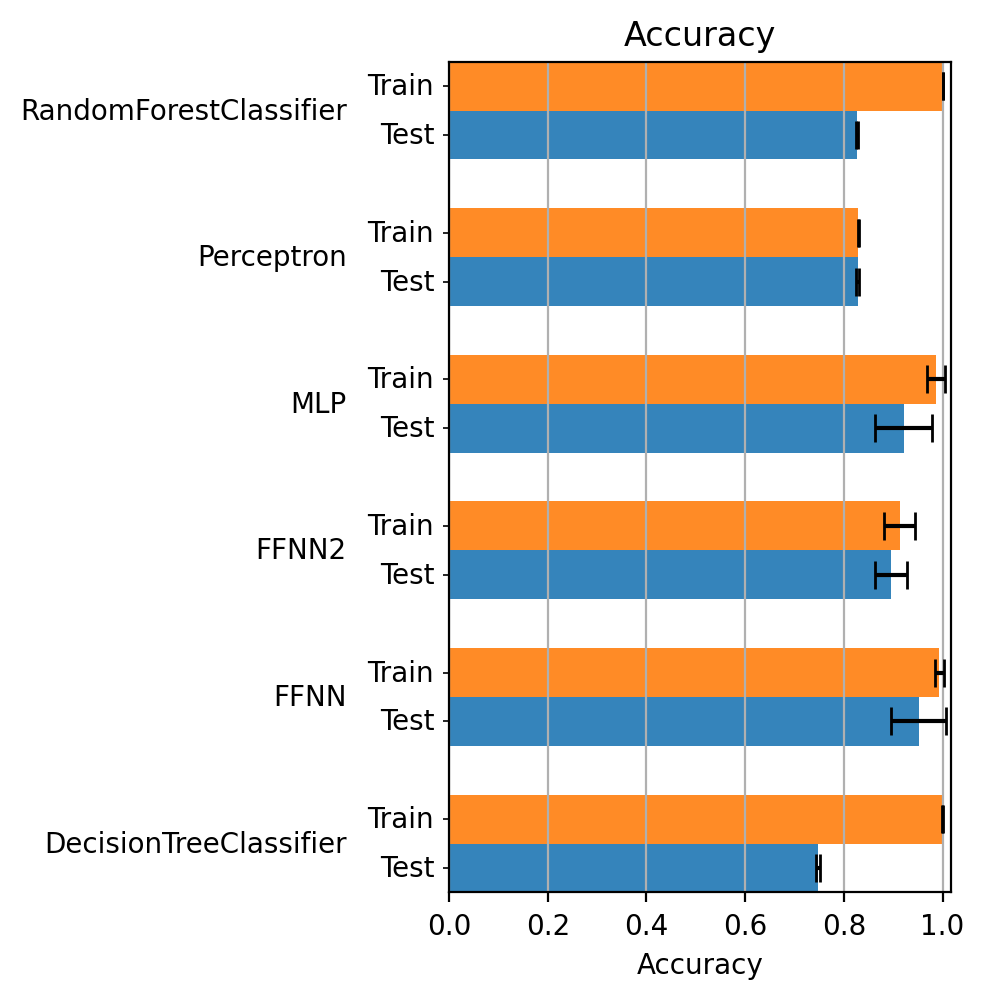

In [20]:
from PIL import Image
from glob import glob

for x in glob("barplots/*.png"):
    display(Image.open(x))

## Statistical tests
To compare the obtained results in a statistically valid manner we need to run a statistical tests. 

Here we will use a Wilcoxon signed-rank test, with p-value $0.01$.

In [69]:
from scipy.stats import wilcoxon

# Here we will be doing a statistical test.
models = df[
    (df.run_type == "test")
]

ffnn_scores = models[models.model=="Perceptron"]
mlp_scores = models[models.model=="DecisionTreeClassifier"]

alpha = 0.01

for metric in ffnn_scores.columns[-4:]:
    print(metric)
    a,  b = ffnn_scores[metric], mlp_scores[metric]
    stats, p_value = wilcoxon(a, b)
    if p_value > alpha:
        print(p_value, "The two models performance are statistically identical.")
    else:
        print(p_value, "The two models performance are different")
        if a.mean() > b.mean():
            print("The first model is better")
        else:
            print("The second model is better")

Accuracy
5.143040123788453e-10 The two models performance are different
The first model is better
Balanced Accuracy
5.145276051717656e-10 The two models performance are different
The first model is better
AUROC
5.145276051717656e-10 The two models performance are different
The first model is better
AUPRC
5.145276051717656e-10 The two models performance are different
The first model is better
